In [11]:
import hdf5storage
from helpers import *
from get_data import *
from synchrony import *
import numpy as np


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading in the bat data (LFP and positional data)
#### We first need to load in the LFP data, which in this case is stored in a MATLAB file. We can do this using ```hdf5storage```. The bat's positional data is stored in a matlab file (not accessible for public use), but luckily the accessors for this data can be found in ```dataset.py``` thanks to the Yartsev Lab.

In [12]:
data_path = './data'
bat_id = '32622'
date = '231007'
lfp_file_path = './data/ephys/32622_231007_lfp.mat'


#Clean up position data (remove NaNs, etc.) and load in LFP from given file path
lfp_mat, cleaned_pos, session = load_and_clean_bat_data(data_path, bat_id, date, lfp_file_path,use_cache=True)

Structure of lfp_data: <class 'numpy.ndarray'>, (1, 2)
Loading Flight Room | 32622 | 231007 from cache...
Positional data shape: (841160, 3)
Cleaned positional data shape: (841160, 3)


### Time synchronization
#### Before we get to the main attraction (the LFP data), we need to ensure our data is synchronized. To do this, we need to extract global timestamps from both the LFP and positional data and make sure they start at the same time.

In [13]:
lfp_timestamps_edges, binned_pos, pos_timestamps, lfp_indices, pos_mask = sync_and_bin_data(lfp_mat, session,cleaned_pos)

#lfp_timestamp_edges stores edges between timebins. this will be useful for aligning the LFP data with the position data
#binned_pos is the cleaned position averaged over the timebins
#pos_mask is a boolean array that marks the non-negative position timestamps
#pos_timestamps is the cleaned and filtered timestamps of the position data
#lfp_indices is a boolean array that marks the non-negative, decimated LFP timestamps


LFP timestamps structure: (17222917, 1)
Decimated LFP timestamps shape: (172230,)
LFP timestamp edges shape: (170691,)
Positional timestamp diff (microseconds): [8333.33333331 8333.33333334 8333.33333334 ... 8333.33772278 8333.33771515
 8333.33771515]
Cleaned positional data shape: (824435, 3)
Binned positional data shape: (170690, 3)


In [14]:
print("Number of NaN values in binned_pos:", np.isnan(binned_pos).sum())


Number of NaN values in binned_pos: 6


#### Inside of ```lfp_timestamps_edges```, we store the *edges* between timebins. We will use this to later to bin the position data; instead of downsampling the data like we did the LFP, we will average across bins (between two edges) of the LFP timebins to get synchronized data streams.

In [15]:
print("First few elements of binned_pos:\n", binned_pos[:, :5]) # NaN values at beginning and end are expected; position is not recorded when bat is not visible.

print("First few LFP bins:", lfp_timestamps_edges[:5])

First few elements of binned_pos:
 [[        nan         nan         nan]
 [-1.35497956 -1.70192085  0.01016301]
 [-1.35496366 -1.70190326  0.01020436]
 ...
 [-1.24507387 -1.627617    0.04300965]
 [-1.24505479 -1.62760721  0.0430833 ]
 [        nan         nan         nan]]
First few LFP bins: [     0.           4514.44262606  44057.00577409  83599.56892214
 123142.1320702 ]


##### Notice above that the LFP timestamp edges have N+1 the shape of the binned position. This makes sense and is expected; `lfp_timestamps_edges` contains the bins (which are stored in groups of two, i.e. the first bin is [0, 4514.4426] and so on) for which the position was binned into.

# Ben splits cluster 3

In [28]:
def left_or_right(x):
    # Use numpy's vectorized operations to determine the labels
    result = np.empty_like(x, dtype=object)  # Create an array to hold the results
    result[x > 0] = "right"  # Assign "right" where x > 0
    result[x == 0] = "0"     # Assign "0" where x == 0
    result[x < 0] = "left"   # Assign "left" where x < 0
    return result


##### getting the binned position to match corresponding flights:
flight_count =0
for flight in session.get_flights_by_cluster([3]): #marking cluster 3 flights
    flight_count +=1
    flight_bool, phase_labels, _ = get_flight_boolean_array(session,flight_count)

    # Apply pos_mask (formerly valid_indices) to the flight boolean array and phase labels
    labels = flight_bool[pos_mask]
    valid_phase_labels = phase_labels[pos_mask] 

     # Label timebins for this flight
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)
    
     # Get binned position data for this flight
    flight_pos = binned_pos[timebin_labels > 0]

    # Adjust valid_phase_labels to match timebin_labels
    adjusted_phase_labels = label_timebins(lfp_timestamps_edges, valid_phase_labels, pos_timestamps, is_discrete=True)
    flight_phases = adjusted_phase_labels[timebin_labels > 0]
    
####### Current analysis task: marking whether current x is less than or greater than x=0

    pos_flight_data = np.column_stack((
        np.full(len(flight_pos), flight_count),
        np.full(len(flight_pos), left_or_right(flight_pos[:,0])),
        flight_pos,
        flight_phases
    ))

## LFP extraction and downsampling

In [22]:
lfp_bat_combined = extract_and_downsample_lfp_data(lfp_mat) #uses scipy decimate to downsample LFP

Type of lfp_data_1: <class 'numpy.ndarray'>, Shape of lfp_data_1: (192, 17222917)
Type of lfp_data_2: <class 'numpy.ndarray'>, Shape of lfp_data_2: (192, 17222917)
Number of channels per array: 192
LFP combined shape: (172230, 384)
Saving LFP data to cache...


In [25]:
LFPs = filter_data(lfp_bat_combined, 1, fs=25, filt_type='high', use_hilbert=True) 
LFPs = LFPs[lfp_indices] # mask for non-negativity 

In [29]:
# code to get flightLFP for a specific cluster (get_flightLFP does so for specific cluster)

flight_count = 0
for flight in session.get_flights_by_cluster([3]):
    flight_count+=1
    flight_bool_phase_labels, phase_labels, _ = get_flight_boolean_array(session,flight_count)
    
    labels = flight_bool[pos_mask]
    valid_phase_labels = phase_labels[pos_mask]
    
    timebin_labels = label_timebins(lfp_timestamps_edges, labels, pos_timestamps, is_discrete=True)

    flight_lfp = LFPs[timebin_labels >0] # mark LFP points which mask to specific flight in cluster
    
     # Adjust valid_phase_labels to match timebin_labels
    adjusted_phase_labels = label_timebins(lfp_timestamps_edges, valid_phase_labels, pos_timestamps, is_discrete=True)
    flight_phases = adjusted_phase_labels[timebin_labels > 0]
    
    # Create flight data for all timebins of this flight
    lfp_flight_data = np.column_stack((
        np.full(len(flight_lfp), flight_count),
        flight_phases,
        flight_lfp
    ))

    

#### We now have our processed LFP. `LFPs` contains the filtered and (Hilbert) transformed LFP data for all of the valid `binned_pos` entries. However, we are mainly interested in the bat flights, which are just a *fraction* of the total of `binned_pos`. To filter out the non-flight entries from the LFP, we will apply a similar filtering method as we did in `get_flightID` with a `get_flightLFP` function:

## training TIMBRE

In [30]:
# Extract left/right labels from pos_flight_data
# Assuming the second column contains "left"/"right"/"0"
pos_labels = pos_flight_data[:, 1]  # Second column
label_mapping = {"left": 0, "right": 1}

# Map the labels to integers
Y = np.array([label_mapping[label] for label in pos_labels if label != "0"])  # Exclude "0"

# Extract the LFP data corresponding to non-"0" labels
X = lfp_flight_data[pos_labels != "0", :]  # Use rows where the labels aren't "0"

In [31]:
from sklearn.model_selection import train_test_split

# Split indices into training and testing sets
inds_train, inds_test = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)


In [32]:
from TIMBRE import TIMBRE

# Parameters for TIMBRE
hidden_nodes = 10
learn_rate = 0.001
is_categorical = True

# Call TIMBRE
model, fitted_model, test_acc = TIMBRE(
    X=X,
    Y=Y,
    inds_test=inds_test,
    inds_train=inds_train,
    hidden_nodes=hidden_nodes,
    learn_rate=learn_rate,
    is_categorical=is_categorical,
    verbosity=1
)

# Print accuracy
print(f"Test Accuracy: {test_acc}")


Test Accuracy: 0.4761904776096344


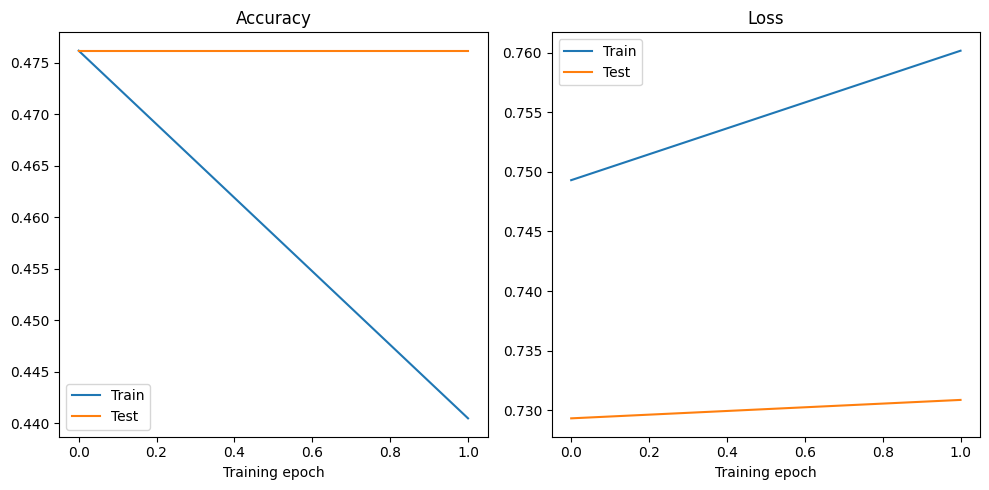

In [33]:
from matplotlib import pyplot as plt

# Plot accuracy and loss from fittedModel
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot training vs. validation accuracy
axs[0].plot(fitted_model.history['accuracy'], label='Train')
axs[0].plot(fitted_model.history['val_accuracy'], label='Test')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Training epoch')
axs[0].legend()

# Plot training vs. validation loss
axs[1].plot(fitted_model.history['loss'], label='Train')
axs[1].plot(fitted_model.history['val_loss'], label='Test')
axs[1].set_title('Loss')
axs[1].set_xlabel('Training epoch')
axs[1].legend()

plt.tight_layout()
plt.show()
